<a href="https://colab.research.google.com/github/shima2920/Kaggle/blob/main/Bike_Sharing_Demand_20210405.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [264]:
#https://www.kaggle.com/general/74235

! pip install -q kaggle

from google.colab import files
files.upload()
#Kaggle account で発行した API token key ファイルを Upload する。

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets list

! kaggle competitions download -c bike-sharing-demand

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              222KB  2021-04-04 08:31:20           1763  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44           1144  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27            897  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:1

# This is Kaggle Competition "Bike Sharing Demand"



https://www.kaggle.com/c/bike-sharing-demand/overview

ref code :https://www.kaggle.com/fatmakursun/bike-sharing-feature-engineering

2021/04/05



*   First Commit

      Score: 1.52760

*   Interpolate windspeed columns, change the method of LightGBM to regression.

     Score: 0.41055


In [1142]:
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder#Label Encoding
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
#import optuna.integration.lightgbm as lgb #LightLGBのハイパーパラメータチューニングモジュールであるOptunaをimport
import lightgbm as lgb_original
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import xgboost as XGBClassifier
from sklearn.model_selection import train_test_split

from keras.layers import Dense, Dropout #Dense : ニューラルネットの層を定義？
from keras.models import Sequential# 複雑なニューラルネットワークモデルを簡略化するためのモデルの一つであるSequentialモデル
from sklearn.preprocessing import StandardScaler #標準化



#Validation
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import KFold


#イテレータ, ループ処理を実行してくれる
import itertools

pd.set_option("display.max_rows", 10000)
pd.set_option('display.max_columns', 1000)
%matplotlib inline

## Load the data

In [1143]:
# load master data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sampleSubmission.csv")

In [1144]:
train.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [1145]:
train.shape

(10886, 12)

In [1146]:
test.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [1147]:
test.shape

(6493, 9)

# Check the data

In [1148]:
from scipy import stats
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [1149]:
resumetable(train)[:25]

Dataset Shape: (10886, 12)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,datetime,object,0,10886,2011-01-01 00:00:00,2011-01-01 01:00:00,2011-01-01 02:00:00,13.41
1,season,int64,0,4,1,1,1,2.00
2,holiday,int64,0,2,0,0,0,0.19
3,workingday,int64,0,2,0,0,0,0.90
4,weather,int64,0,4,1,1,1,1.19
5,temp,float64,0,49,9.84,9.02,9.02,5.18
6,atemp,float64,0,60,14.395,13.635,13.635,5.37
7,humidity,int64,0,89,81,80,80,6.01
8,windspeed,float64,0,28,0,0,0,3.83
9,casual,int64,0,309,3,8,5,6.43


In [1150]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [1151]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


no missing data in train.

some values in humidity and windspeed is zero that means NaN value.

In [1152]:
resumetable(test)[:25]

Dataset Shape: (6493, 9)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,datetime,object,0,6493,2011-01-20 00:00:00,2011-01-20 01:00:00,2011-01-20 02:00:00,12.66
1,season,int64,0,4,1,1,1,2.00
2,holiday,int64,0,2,0,0,0,0.19
3,workingday,int64,0,2,1,1,1,0.90
4,weather,int64,0,4,1,1,1,1.22
5,temp,float64,0,49,10.66,10.66,10.66,5.19
6,atemp,float64,0,65,11.365,13.635,13.635,5.43
7,humidity,int64,0,79,56,56,56,5.92
8,windspeed,float64,0,27,26.0027,0,0,3.82


In [1153]:
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


no missing data in test.

#  EDA for train data

In [1154]:
train_df = train.copy()

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 <a list of 8 Text major ticklabel objects>)

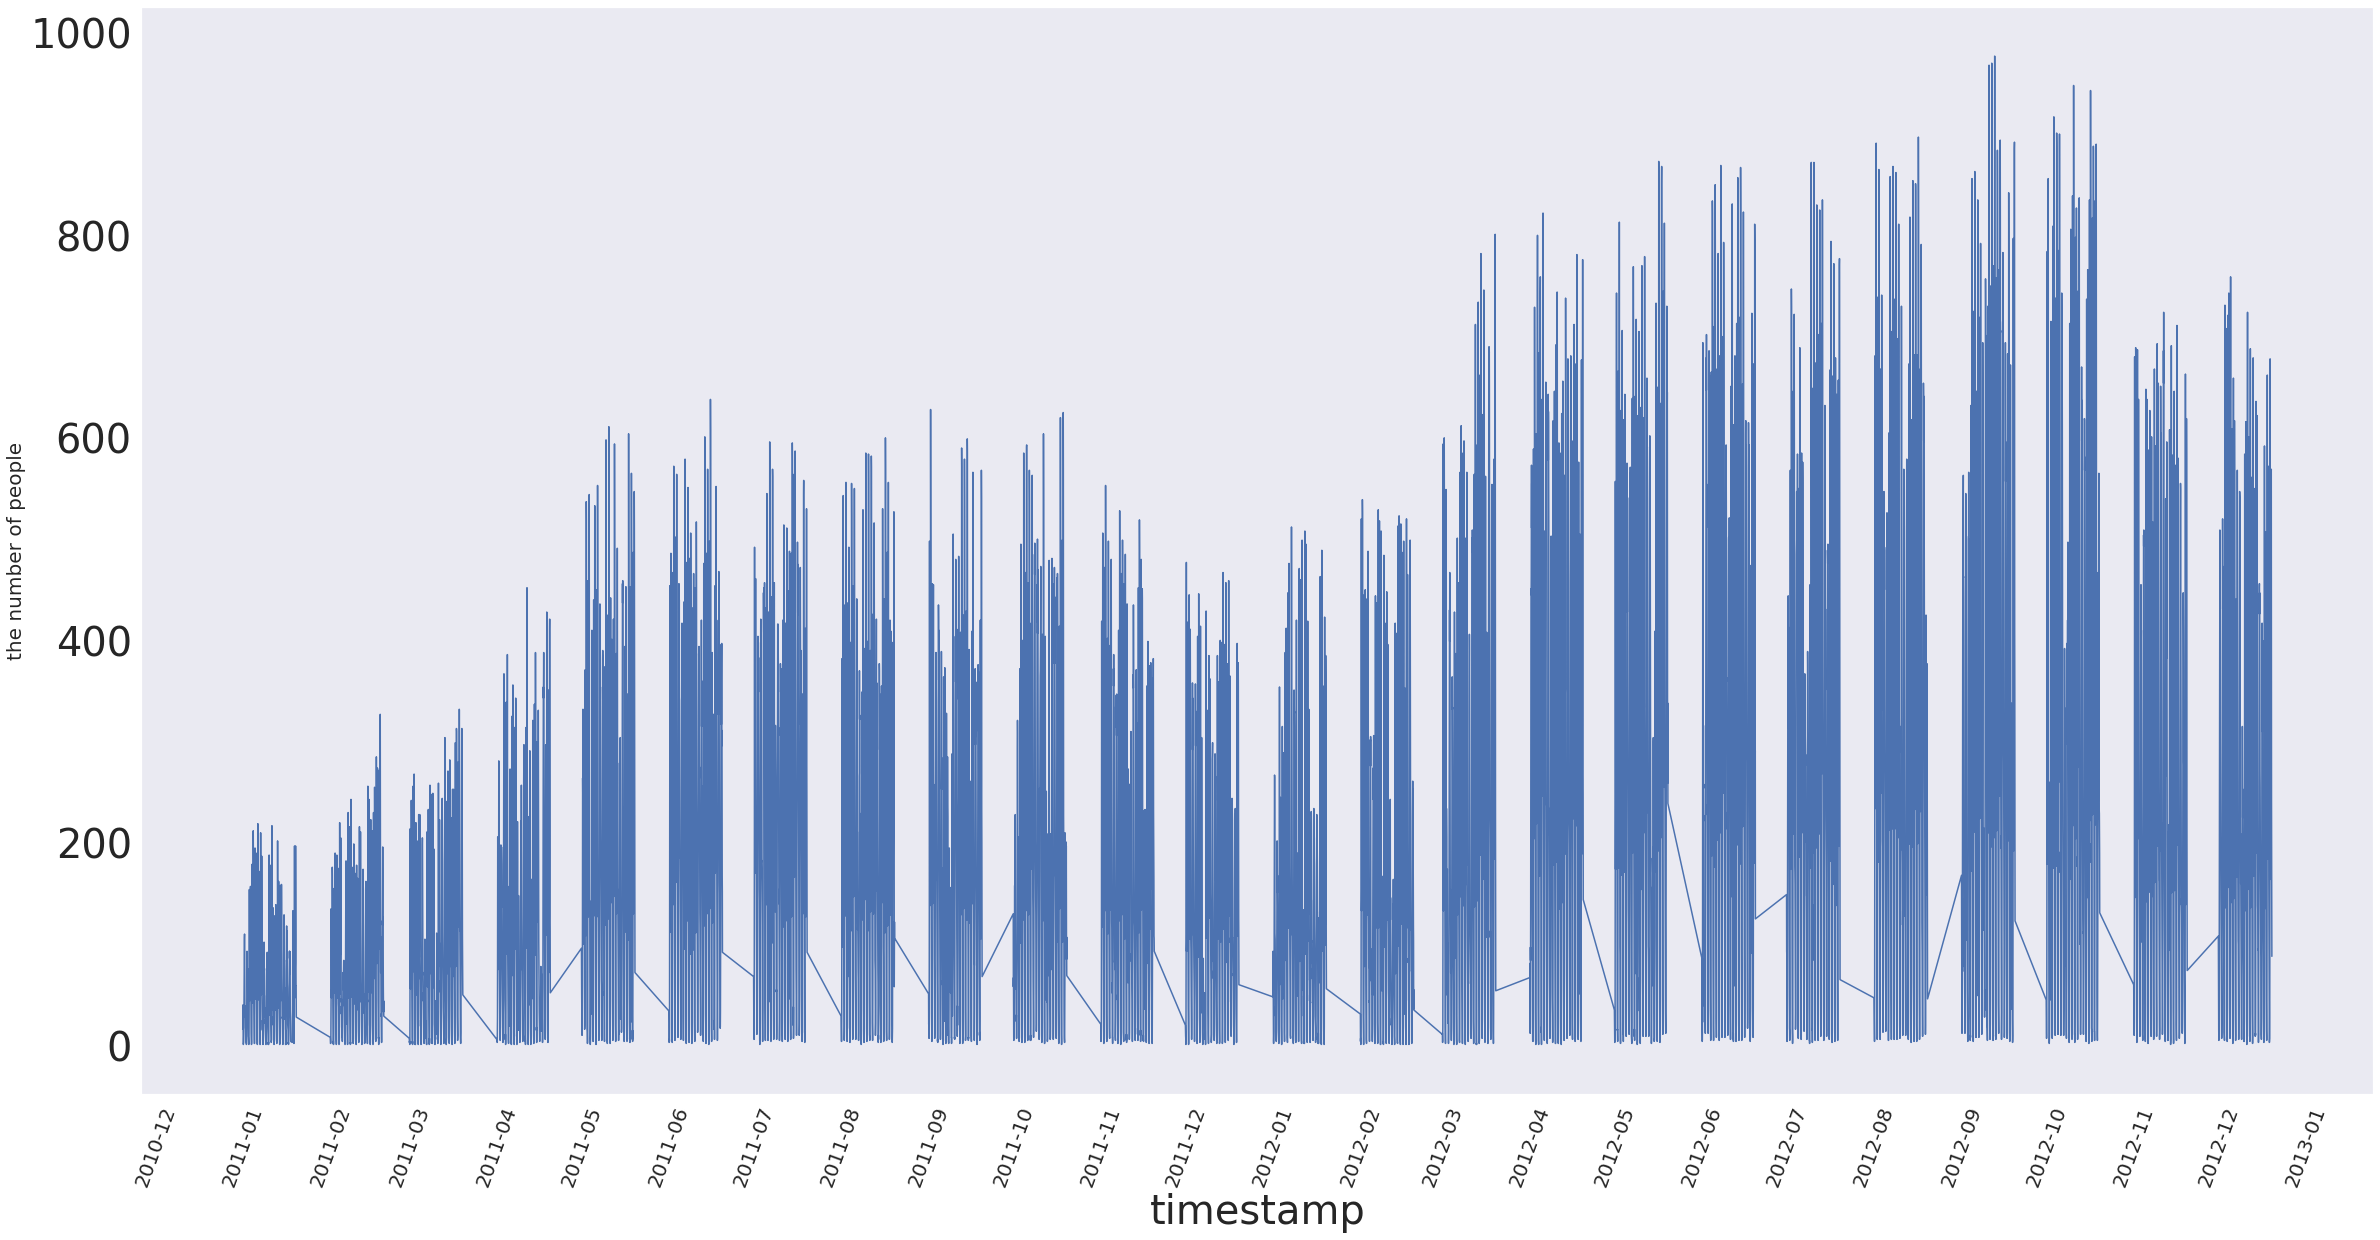

In [1155]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(40, 20))
ax.plot(pd.to_datetime(train_df["datetime"]), train_df["count"])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.grid()
plt.xlabel("timestamp", fontsize=40)
plt.ylabel("the number of people", fontsize=20)
plt.xticks(fontsize=20)
plt.setp(ax.get_xticklabels(), rotation=70)
plt.yticks(fontsize=40)

In [1156]:
# Define time series analysis function
def plot_ts_decomp(data, col, lag, color):
    print("Analised Data:{}".format(col.upper()))
    # Stats model
    res = sm.tsa.seasonal_decompose(data[col], freq=lag)
    data["trend"] = res.trend
    data["seaso"] = res.seasonal
    data["resid"] = res.resid
    
    # Visualization
    fig = plt.figure(figsize=(20,15))
    grid = plt.GridSpec(4,2, hspace=0.4, wspace=0.2)
    ax1 = fig.add_subplot(grid[0,0])
    ax2 = fig.add_subplot(grid[1,0])
    ax3 = fig.add_subplot(grid[2,0])
    ax4 = fig.add_subplot(grid[3,0])
    ax5 = fig.add_subplot(grid[:-2,1])
    ax6 = fig.add_subplot(grid[2:,1])
    
    # raw the number of people data
    ax1.plot(data.index, data[col], label="the number of people of {}".format(col), color=color, linewidth=0.5)
    ax1.plot(data.index, data[col].rolling(lag//12).mean(), label="Rolling {}".format(lag//12), color=color, linewidth=2)
    ax1.set_xlabel("date")
    ax1.set_ylabel("the number of people")
    ax1.set_title("raw data")
    ax1.legend()
    # trend
    ax2.plot(data.index, data["trend"], label="trend of {}".format(col), color=color, linewidth=3)
    ax2.set_xlabel("date")
    ax2.set_ylabel("trend")
    ax2.set_title("trend")
    ax2.legend()
    # seasonaly
    ax3.plot(data.index, data["seaso"], label="seasonaly of {}".format(col), color=color, linewidth=0.5)
    ax3.set_xlabel("date")
    ax3.set_ylabel("seasonaly")
    ax3.set_title("seasonaly")
    ax3.legend()
    # residual
    ax4.plot(data.index, data["resid"], label="residual error of {}".format(col), color=color, linewidth=0.5)
    ax4.set_xlabel("date")
    ax4.set_ylabel("residual error")
    ax4.set_title("residual")
    ax4.legend()
    # distribution
    sns.distplot(data[col], ax=ax5)
    ax5.set_xlabel("the number of people")
    ax5.set_ylabel("Frequency")
    ax5.set_title("distribution")
    # auto correlation
    autocorrelation_plot(data[col], ax=ax6, linewidth=0.5)
    ax6.set_title("autocorrelation")

Analised Data:COUNT


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


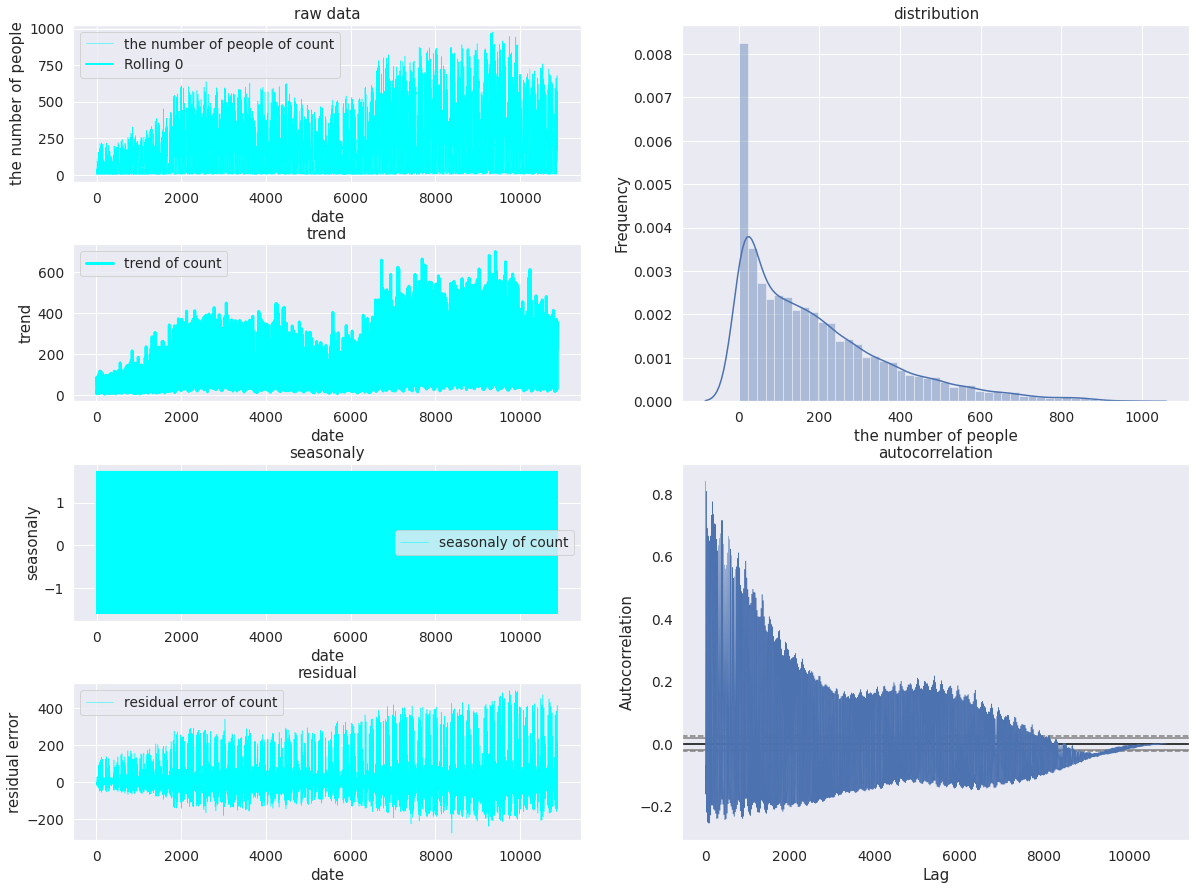

In [1157]:
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
# CA of state
plot_ts_decomp(train_df, "count", 7, "aqua");

It seems the data over 500 cnt are outlier.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


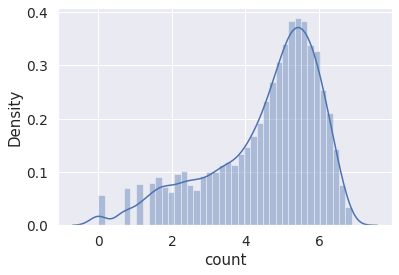

0        2.772589
1        3.688879
2        3.465736
3        2.564949
4        0.000000
           ...   
10881    5.817111
10882    5.484797
10883    5.123964
10884    4.859812
10885    4.477337
Name: count, Length: 10886, dtype: float64


In [1158]:
#from scipy.stats import boxcox
train_df['count']=train_df['count'].apply(lambda x:np.log(x))
#train_df['count']=boxcox(train_df['count'])[0]
sns.distplot(train_df['count'])
plt.show()
print (train_df['count'])

# remove the outlier

In [1159]:
def CalcOutliers(df_num): 

    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print("upper:", upper)
    print("lower:", lower)
    print("-"*30)
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return

In [1160]:
CalcOutliers(train["count"])

upper: 734.982532635345
lower: -351.8342688102485
------------------------------
Identified lowest outliers: 0
Identified upper outliers: 147
Total outlier observations: 147
Non-outlier observations: 10739
Total percentual of Outliers:  1.3688


In [1161]:
train.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


# remove the unnecessary column

In [1162]:
train = train.drop(['casual'], axis = 1)
train = train.drop(['registered'], axis = 1)
#train = train.drop(['atemp'], axis = 1)

In [1163]:
#test = test.drop(['atemp'], axis = 1)

# interpolate the values in humidity and windspeed

In [1164]:
'''
train['windspeed'] = train['windspeed'].replace(0,np.NaN)
train['humidity'] = train['humidity'].replace(0,np.NaN)
test['windspeed'] = test['windspeed'].replace(0,np.NaN) 
test['humidity'] = test['humidity'].replace(0,np.NaN) 
'''


"\ntrain['windspeed'] = train['windspeed'].replace(0,np.NaN)\ntrain['humidity'] = train['humidity'].replace(0,np.NaN)\ntest['windspeed'] = test['windspeed'].replace(0,np.NaN) \ntest['humidity'] = test['humidity'].replace(0,np.NaN) \n"

In [1165]:
'''
train = train.groupby('humidity').apply(lambda group: group.interpolate(limit_direction='both'))
train = train.groupby('windspeed').apply(lambda group: group.interpolate(limit_direction='both'))
'''


"\ntrain = train.groupby('humidity').apply(lambda group: group.interpolate(limit_direction='both'))\ntrain = train.groupby('windspeed').apply(lambda group: group.interpolate(limit_direction='both'))\n"

In [1166]:
'''
test = test.groupby('humidity').apply(lambda group: group.interpolate(limit_direction='both'))
test = test.groupby('windspeed').apply(lambda group: group.interpolate(limit_direction='both'))
'''


"\ntest = test.groupby('humidity').apply(lambda group: group.interpolate(limit_direction='both'))\ntest = test.groupby('windspeed').apply(lambda group: group.interpolate(limit_direction='both'))\n"

In [1167]:
train['windspeed'] = train['windspeed'].replace(0,np.NaN)
test['windspeed'] = test['windspeed'].replace(0,np.NaN) 

train['windspeed'].fillna(method='bfill',inplace=True)
train['windspeed'] = train['windspeed'].interpolate()
test['windspeed'] = test['windspeed'].interpolate()

In [1168]:
train.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,6.0032,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,6.0032,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,6.0032,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,6.0032,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,6.0032,1


# split the datetime

In [1169]:
train["datetime"] = pd.to_datetime(train["datetime"])
train["Year"] = train["datetime"].apply(lambda x:x.year)
train["Month"] = train["datetime"].apply(lambda x:x.month)
train["Day"] = train["datetime"].apply(lambda x:x.day)
train['weekday'] = train["datetime"].apply(lambda x: x.weekday())
train["hour"] = train["datetime"].apply(lambda x:x.hour)

In [1170]:
test["datetime"] = pd.to_datetime(test["datetime"])
test["Year"] = test["datetime"].apply(lambda x:x.year)
test["Month"] = test["datetime"].apply(lambda x:x.month)
test["Day"] = test["datetime"].apply(lambda x:x.day)
test['weekday'] = test["datetime"].apply(lambda x: x.weekday())
test["hour"] = test["datetime"].apply(lambda x:x.hour)

In [1171]:
train = train.set_index("datetime")

In [1172]:
test = test.set_index("datetime")

In [1173]:
train.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,Year,Month,Day,weekday,hour
datetime,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,6.0032,16,2011,1,1,5,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,6.0032,40,2011,1,1,5,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,6.0032,32,2011,1,1,5,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,6.0032,13,2011,1,1,5,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,6.0032,1,2011,1,1,5,4


In [1174]:
test.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,Year,Month,Day,weekday,hour
datetime,,,,,,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.002700,2011,1,20,3,0
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,21.002267,2011,1,20,3,1
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,16.001833,2011,1,20,3,2
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.001400,2011,1,20,3,3
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.001400,2011,1,20,3,4


In [1175]:
train.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'count', 'Year', 'Month', 'Day', 'weekday',
       'hour'],
      dtype='object')

# Correlation

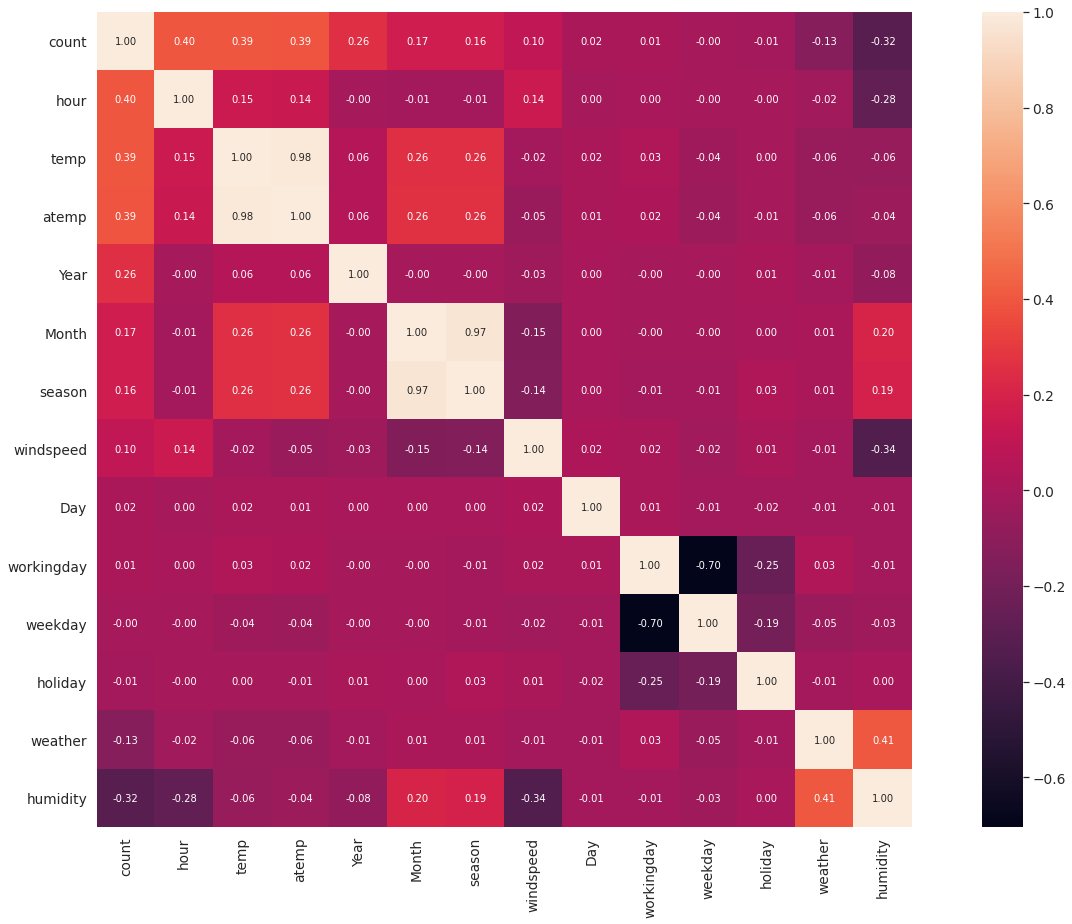

In [1176]:
#correlation matrix
plt.figure(figsize=(25,15))
k = len(train.columns) #number of variables for heatmap
corrmat = train.corr()
cols = corrmat.nlargest(k, 'count')['count'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# One-hot encoding

In [1177]:
'''
weather_df=pd.get_dummies(train['weather'],prefix='w')
year_df=pd.get_dummies(train['Year'],prefix='y')
month_df=pd.get_dummies(train['Month'],prefix='m')
hour_df=pd.get_dummies(train['hour'],prefix='h')
season_df=pd.get_dummies(train['season'],prefix='s')
'''


"\nweather_df=pd.get_dummies(train['weather'],prefix='w')\nyear_df=pd.get_dummies(train['Year'],prefix='y')\nmonth_df=pd.get_dummies(train['Month'],prefix='m')\nhour_df=pd.get_dummies(train['hour'],prefix='h')\nseason_df=pd.get_dummies(train['season'],prefix='s')\n"

In [1178]:
'''
train=train.join(weather_df)
train=train.join(year_df)
train=train.join(month_df)                     
train=train.join(hour_df)
train=train.join(season_df)
'''


'\ntrain=train.join(weather_df)\ntrain=train.join(year_df)\ntrain=train.join(month_df)                     \ntrain=train.join(hour_df)\ntrain=train.join(season_df)\n'

In [1179]:
'''
weather_df=pd.get_dummies(test['weather'],prefix='w')
year_df=pd.get_dummies(test['Year'],prefix='y')
month_df=pd.get_dummies(test['Month'],prefix='m')
hour_df=pd.get_dummies(test['hour'],prefix='h')
season_df=pd.get_dummies(test['season'],prefix='s')
'''


"\nweather_df=pd.get_dummies(test['weather'],prefix='w')\nyear_df=pd.get_dummies(test['Year'],prefix='y')\nmonth_df=pd.get_dummies(test['Month'],prefix='m')\nhour_df=pd.get_dummies(test['hour'],prefix='h')\nseason_df=pd.get_dummies(test['season'],prefix='s')\n"

In [1180]:
'''
test=test.join(weather_df)
test=test.join(year_df)
test=test.join(month_df)                     
test=test.join(hour_df)
test=test.join(season_df)
'''


'\ntest=test.join(weather_df)\ntest=test.join(year_df)\ntest=test.join(month_df)                     \ntest=test.join(hour_df)\ntest=test.join(season_df)\n'

In [1181]:
'''
train.head(5)
'''


'\ntrain.head(5)\n'

# Split train and test data

In [1182]:
train.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,Year,Month,Day,weekday,hour
datetime,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,6.0032,16,2011,1,1,5,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,6.0032,40,2011,1,1,5,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,6.0032,32,2011,1,1,5,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,6.0032,13,2011,1,1,5,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,6.0032,1,2011,1,1,5,4


In [1183]:
'''
x_train = train.drop(['count'], axis = 1)
y_train = train['count']

#target value を対数変換する
y_train = np.log1p(y_train)
'''

"\nx_train = train.drop(['count'], axis = 1)\ny_train = train['count']\n\n#target value を対数変換する\ny_train = np.log1p(y_train)\n"

In [1184]:
x_train =train.iloc[:,train.columns!='count'].values
print (x_train)

y_train =train.iloc[:,8].values

print (y_train)

[[ 1.  0.  0. ...  1.  5.  0.]
 [ 1.  0.  0. ...  1.  5.  1.]
 [ 1.  0.  0. ...  1.  5.  2.]
 ...
 [ 4.  0.  1. ... 19.  2. 21.]
 [ 4.  0.  1. ... 19.  2. 22.]
 [ 4.  0.  1. ... 19.  2. 23.]]
[ 16  40  32 ... 168 129  88]


In [1185]:
#target value を対数変換する
y_train = np.log1p(y_train)
y_train 

array([2.83321334, 3.71357207, 3.49650756, ..., 5.12989871, 4.86753445,
       4.48863637])

In [1186]:
test =test.values

In [1187]:
test

array([[ 1.,  0.,  1., ..., 20.,  3.,  0.],
       [ 1.,  0.,  1., ..., 20.,  3.,  1.],
       [ 1.,  0.,  1., ..., 20.,  3.,  2.],
       ...,
       [ 1.,  0.,  1., ..., 31.,  0., 21.],
       [ 1.,  0.,  1., ..., 31.,  0., 22.],
       [ 1.,  0.,  1., ..., 31.,  0., 23.]])

# LightGBM

In [1188]:
# Train/validation用にデータ分割
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(x_train,y_train,test_size=0.2,random_state=42)

In [1189]:
#LightGBM用のデータ作成
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_valid = lgb.Dataset(X_test, Y_test, reference=lgb_train)

In [1190]:
# to record eval results for plotting
evals_result = {}

In [1191]:
#OptunaチューニングParam
optuna_params = {
    'task': 'train',
    #'boosting_type': 'gbdt',
    'objective': 'mean_squared_error',# regression(回帰), binary(二値分類, ラベルは0,1),multiclass(多クラス分類, metricとしては、multi_logloss, multi_error(正答率))
    'metric': "regression", #regression : 絶対値誤差関数(L1)ならばmae, 2乗誤差関数(L2)ならばmseと指定, rmse
                      #binary : binary_logloss(クロスエントロピー)とbinary_error(正答率)の2つ
                      #multiclass : multi_logloss(softmax関数)とmulti_error(正答率)の2つ
    #'num_leaves': 20,#木にある分岐の個数．デフォルトは31, 大きくすると精度は上がるが過学習が進む
    #'max_depth': 10,#木構造の深さを限定するための変数．データが少ないときに過学習を防ぐために設定する．デフォルト値は-1で0以下の値は制限なしを意味する．
    #'learning_rate': 0.05,#学習率。デフォルトは0.1
    #'feature_fraction': 0.9,#学習の高速化と過学習の抑制に使用される．データの特徴量のfeature_fraction * 100 % だけ使用する．
    #'min_data_in_leaf':4,#大きくすることでデータと分岐が1対1対応することを防ぎ，結果として過学習を抑制する．
    #'verbose':50
}

In [1192]:
#Optunaを用いて最適化し、LGBにTrainさせる
model = lgb.train(optuna_params,
                  lgb_train,
                  valid_sets=lgb_valid,
                  verbose_eval=0,
                  num_boost_round=1000,
                  early_stopping_rounds=50
                  )


In [1193]:
y_pred_test = model.predict(X_test, num_iteration=model.best_iteration)

In [1194]:
# eval rmse
print('\nThe rmse of prediction is:', mean_squared_error(Y_test, y_pred_test) ** 0.5)
accuracy = mean_squared_error(Y_test, y_pred_test) ** 0.5


The rmse of prediction is: 0.2770090869405684


In [1195]:
best_params = model.params
print("Best params:", best_params)
print("  Accuracy = {}".format(accuracy))
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best params: {'task': 'train', 'objective': 'mean_squared_error', 'metric': 'regression'}
  Accuracy = 0.2770090869405684
  Params: 
    task: train
    objective: mean_squared_error
    metric: regression


In [1196]:
y_pred = model.predict(test, num_iteration=model.best_iteration)

In [1197]:
y_pred =np.exp(y_pred) 

# Submit the prediction result

In [1198]:
sample.head(5)

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [1199]:
#Submit方法
sub = pd.DataFrame(pd.read_csv('sampleSubmission.csv')['datetime'])
sub['count'] = list(map(int, y_pred))
sub.to_csv('submission_yshimamu.csv', index=False)

In [1200]:
!kaggle competitions submit bike-sharing-demand -f submission_yshimamu.csv -m "First commit"

100% 149k/149k [00:03<00:00, 44.6kB/s]
Successfully submitted to Bike Sharing Demand